# Active Learning - Committee-Based Sampling

The purpose of this notebook is to demonstrate the Active Learning technique: Committee-Based Sampling.

The notebook has been developed by Assaf Landschaft and Bernard Mcshea for the "in class paper presentation" for the course "CSCI E-81 Section 2 2016" in Harvard Extension School.

## What is Active Learning

The goal of active learning is to minimize annotation costs. In other words – to minimize the costs of creating sufficient training data for a supervised learning algorithm. The standard approach to supervised learning is to acquire a large random sample of training instances to be labeled before any learning begins. When labeling costs are high, Active Learning algorithms are used to select the most informative unlabeled instances so only those will be annotated.


## Standard imports and settings

In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.size'] = 16.0
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd            # process data with pandas dataframe
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import time
import os

# The data 

The **Ohsumed** test collection (available at <ftp://medir.ohsu.edu/pub/ohsumed>) is a subset of the MEDLINE database, which is a bibliographic database of important, peer-reviewed medical literature maintained by the National Library of Medicine. The initial subset I consider in the project is the collection consisting of the first 20,000 documents from the 50,216 medical abstracts of the year 1991. The classification scheme consists of the 23 Medical Subject Headings (MeSH) categories of cardiovascular diseases group: 

| Category      | Description   |        
| ------------- | ------------- |
| C01 | Bacterial Infections and Mycoses |
| C02 | Virus Diseases |
| C03 | Parasitic Diseases |
| C04 | Neoplasms |
| C05 | Musculoskeletal Diseases |
| C06 | Digestive System Diseases |
| C07 | Stomatognathic Diseases |
| C08 | Respiratory Tract Diseases |
| C09 | Otorhinolaryngologic Diseases |
| C10 | Nervous System Diseases |
| C11 | Eye Diseases |
| C12 | Urologic and Male Genital Diseases |
| C13 | Female Genital Diseases and Pregnancy Complications |
| C14 | Cardiovascular Diseases |
| C15 | Hemic and Lymphatic Diseases |
| C16 | Neonatal Diseases and Abnormalities |
| C17 | Skin and Connective Tissue Diseases |
| C18 | Nutritional and Metabolic Diseases |
| C19 | Endocrine Diseases |
| C20 | Immunologic Diseases |
| C21 | Disorders of Environmental Origin |
| C22 | Animal Diseases |
| C23 | Pathological Conditions, Signs and Symptoms |


## Downloading the data:

* [Cardiovascular diseases abstracts](http://disi.unitn.it/moschitti/corpora/ohsumed-first-20000-docs.tar.gz) (the first 20,000 abstracts of the year 1991)

** The following code assumes that the data is extracted into folder with the name 'Data' in the same folder of the IPython notebook**

## Storing the data in a sql database

The following code iterates over the extracted data and converts the ohsumed directory structure to a single sqlite databse with the data. The original dataset is already divided to Test and Training datasets. We will keep this division.

In [3]:
import sqlite3 as sqlite

def get_all_tables(c):
    """
    Helper function - Gets a list of all the tables in the database.
    """
    all_tables = []
    c.execute('SELECT name FROM SQLITE_MASTER WHERE type = "table"')
    for tbl in c:
        all_tables.append(tbl[0])
    return all_tables

def drop_tables(c, tables):
    """
    Helper function - Checks that the specified tables exist, and for those that do, drop them.
    """
    all_tables = get_all_tables(c)
    for t in tables:
        if t in all_tables:
            c.execute('DROP TABLE %s' % t)

def create_documents_table(c):
    """
    Helper function - This function uses SQL to create the Documents table
    """
    drop_tables(c, [ 'Documents' ])
    c.execute("""CREATE TABLE Documents ( 
            DOCID TEXT PRIMARY KEY,
            NOTE_TEXT TEXT, 
            CATEGORY TEXT
        )""")

def add_document(c, docid, text, category):
    """
    Helper function - Adds one document to sql Documents database
    """
    c.execute('insert or replace into Documents values ( ?, ?, ? )', (docid, text, category))

def ohsumed2sqlite(src_root_dir, dest_sqlite):
    start_time = time.time()
    print ('Converting ohsumed directory structure {0} to sqlite database'.format(src_root_dir))

    conn_out = sqlite.connect(dest_sqlite)
    c_out = conn_out.cursor()

    fout = open(dest_sqlite, 'w')
    fout.close()

    create_documents_table(c_out)
    # Process the ohsumed directory
    dict = {}
    for root, dirs, files in os.walk(src_root_dir):
        for f in files:
            category = os.path.basename(root) # directory name is the category
            with open (os.path.join(root, f), "r") as cur_file:
                data=cur_file.read()
                if f in dict:
                    category = dict[f] + ',' + category
                dict[f] = category
                add_document(c_out, f, data, category)
    conn_out.commit()
    c_out.close()
    print("--- ohsumed2sqlite %s seconds ---" % (time.time() - start_time))

In [4]:
# Convert the training data
ohsumed2sqlite('.\\Data\\ohsumed-first-20000-docs\\training', 'training.sqlite')

# Convert the test data
ohsumed2sqlite('.\\Data\\ohsumed-first-20000-docs\\test', 'test.sqlite')

Converting ohsumed directory structure .\Data\ohsumed-first-20000-docs\training to sqlite database
--- ohsumed2sqlite 18.718414545059204 seconds ---
Converting ohsumed directory structure .\Data\ohsumed-first-20000-docs\test to sqlite database
--- ohsumed2sqlite 23.18361735343933 seconds ---


## Data exploration and preparation 



### Read the data from the sqlite databases into Pandas dataframes

In [5]:
con = sqlite.connect('training.sqlite')

df_train = pd.read_sql_query("SELECT * from Documents", con)

con.close()

con = sqlite.connect('test.sqlite')

df_test = pd.read_sql_query("SELECT * from Documents", con)

con.close()


### Output a random sample of 20 records

In [6]:
pd.options.display.max_colwidth = 200

df_train.sample(20)

,DOCID,NOTE_TEXT,CATEGORY
3462,0003032,The operative management of coexisting thyroid and parathyroid disease.\n Three hundred eight patients who underwent operation for hyperparathyroidism were studied.\n Fifty-two (17%) were identifi...,"C04,C19"
2216,0002938,"Intraoperative ultrasonic imaging of the ascending aorta in ischemic heart disease.\n In an attempt to locate any atherosclerotic lesion in the ascending aorta and to prevent embolization, intraop...","C10,C14"
2254,0003155,Increase of calmodulin activator in hypertension. Modulation by dietary sodium and calcium.\n The aim of this study was to investigate the effects of dietary calcium and sodium on blood pressure (...,C14
1821,0009426,"Shortening of the hemodialysis procedure and mortality in ""healthy"" dialysis patients.\n The influence of shortening chronic hemodialysis on mortality was studied by following cumulative survival ...",C12
4616,0000765,Lumbar intervertebral disc prolapse in teenage twins. A case report and review of the literature.\n We report the cases of teenage twin girls presenting within months of each other with severe sym...,"C05,C23"
40,0004625,Monoclonal antibody to mouse lipopolysaccharide receptor protects mice against the lethal effects of endotoxin.\n Specific endotoxic lipopolysaccharide (LPS) binding sites on the cell membranes of...,C01
3948,0009138,"Cardiovascular anomalies associated with prenatal exposure to theophylline.\n Theophylline has been shown to be a potent cardiovascular teratogen in animals, but there has been no evidence linking...","C13,C16,C20"
1842,0009576,One year of rHuEPO therapy prolongs RBC survival and may stabilize RBC membranes despite natural progression of chronic renal failure to uremia and need for dialysis.\n rHuEPO was administered to ...,C12
2155,0002348,"Percutaneous excimer laser coronary angioplasty.\n To determine the efficacy of percutaneous excimer laser coronary angioplasty as an adjunct or alternative to conventional balloon angioplasty, 55...",C14
1877,0002521,Contraception and ectopic pregnancy risk.\n Studies of the association of ectopic pregnancy with contraception have generated a conflicting array of results because of methodologic differences bet...,C13


### Creating binary classification dataset

** As we see, each document is assigned one class or more. ** In this exercise I would like to implement a simple binary classification workflow, so I define 2 binary classes:
* **Positive / True** - Documents that belong to class **C14 - Cardiovascular Diseases**
* **Negative / False** - Documents that do not belong to C14

The following code converts that data to a binary classification dataset:


In [7]:
import re

def ConvertCategoryColToBinVal(df, poscat):
    df['CATEGORY'] = df['CATEGORY'].apply(lambda x: bool(re.search(poscat, x, re.IGNORECASE) and True))
    
ConvertCategoryColToBinVal(df_train, 'C14')

ConvertCategoryColToBinVal(df_test, 'C14')

Let's take another look at the data:

In [8]:
df_train.sample(20)

,DOCID,NOTE_TEXT,CATEGORY
551,0008799,"Immunohistochemical differentiation of basal cell epithelioma from cutaneous appendages using monoclonal anti-glycoprotein antibody TNKH1. Its application in Mohs' micrographic surgery.\n TNKH1, w...",False
4911,0003175,Cardiac arrhythmias from a malpositioned Greenfield filter in a traumatic quadriplegic.\n A case study is presented of premature Greenfield filter discharge with intracardiac migration and resulti...,True
4145,0003819,Electrolyte abnormalities in the alcoholic patient.\n The acute effect of ethyl alcohol ingestion is to induce diuresis with excretion of free water and preservation of electrolytes.\n This occurs...,False
3822,0006720,"Formoterol, a new inhaled beta-2 adrenergic agonist, has a longer blocking effect than albuterol on hyperventilation-induced bronchoconstriction.\n The duration of effect of inhaled formoterol (24...",False
3385,0008432,Lovastatin decreases coenzyme Q levels in humans.\n Lovastatin is clinically used to treat patients with hypercholesterolemia and successfully lowers cholesterol levels.\n The mechanism of action ...,True
1835,0009521,A prospective randomized evaluation of chronic peritoneal catheters. Insertion site and intraperitoneal segment.\n The insertion site (midline or through the lateral rectus muscle) and type of chr...,False
1165,0008657,Ventilator dependency in the United Kingdom.\n There are 24 children who are currently long term ventilator dependent in the UK.\n Nine of these are cared for entirely at home.\n An additional 11 ...,False
904,0008464,"Congenital biliary tract disease.\n Jaundice in the pediatric patient requires prompt and directed evaluation.\n This dictum is highlighted in infants with biliary atresia, in whom the progressive...",False
6076,0008969,"Induction of RNA-stabilized DNA conformers by transcription of an immunoglobulin switch region \n A deletion DNA rearrangement is associated with immunoglobulin class switching from IgM to IgG, Ig...",False
1325,0003893,Efficacy and safety of vagus nerve stimulation in patients with complex partial seizures.\n A clinical trial of chronic intermittent vagal stimulation in five patients suggests that the procedure ...,False


### How many records do we have in the test / train datasets ?

In [9]:
print ('Training data has: ', len(df_train.index), ' documents')

print ('Test data has: ', len(df_test.index), ' documents')

Training data has:  6286  documents
Test data has:  7643  documents


### Data distribution

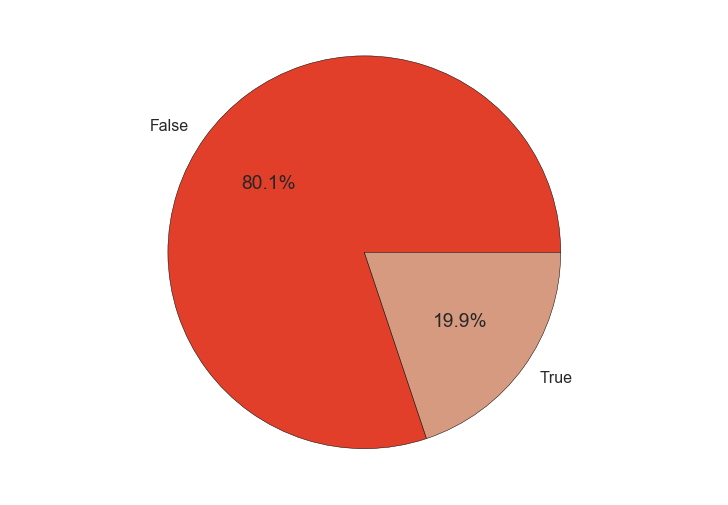

In [10]:
plt.axis('equal')
plt.pie(
    df_train.CATEGORY.value_counts().tolist(), 
    labels=['False', 'True'], 
    autopct='%1.1f%%', 
    colors=("#E13F29", "#D69A80"));

**The accuracy of a dumb classifier that classifies all the documents as False is >80%**

# Define Target classifier and test method

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score


from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
import string

stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [item for item in tokens if item.isalpha()]
    stems = stem_tokens(tokens, stemmer)
    return stems

def RenderConfusionMatrix(ytrue, ypred):
    """
    Helper function - renders confusion matrix
    """
    print(pd.crosstab(pd.Series(ytrue), pd.Series(ypred), rownames=['Actual'], colnames=['Predicted'], margins=True)) 


def TrainAndClassify_SVM(df_train, df_test):
    """
    Trains the target classifier with the df_train DataFrame dataset and then 
    classifies df_test DataFrame dataset, compares the classification results to
    the real labels and outputs the performance
    """    
    
    # Make sure there are no NaNs in the input
    df_train = df_train.dropna(subset=['NOTE_TEXT'])
    df_test = df_test.dropna(subset=['NOTE_TEXT'])
    
    
    text_clf_pipeline = Pipeline([('vect', CountVectorizer()),
                                  ('tfidf', TfidfTransformer()),
                                  ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=0.002, n_iter=10, random_state=314)),
                                 ])

    # Fit a classifier to the training data
    text_clf_pipeline.fit(df_train['NOTE_TEXT'].tolist(), df_train.CATEGORY.tolist())
    
    # Make predictions on the test data
    predictions = text_clf_pipeline.predict(df_test['NOTE_TEXT'].tolist())
    
    # Render confusion matrix
    RenderConfusionMatrix(df_test.CATEGORY.tolist(), predictions)
    
    # Output performance
    print ()
    print ('Accuracy: ', accuracy_score(df_test.CATEGORY.tolist(), predictions))
    print ()
    print (classification_report(df_test.CATEGORY.tolist(), predictions))

# Create and explore an initial training set of 200 documents

<img src="BASELINE.png">

In [12]:
def ExploreData(df):
    """
    Helper function - data exploration
    """
    print ('Training data has: ', len(df.index), ' documents')
    print (df.columns)
    print ('The shape of the data is ', (df.shape))
    plt.axis('equal')
    plt.pie(
        df.CATEGORY.value_counts().tolist(), 
        labels=['False', 'True'], 
        autopct='%1.1f%%', 
        colors=("#E13F29", "#D69A80"));

In [13]:
K = 200 # Size of the initial training set
L = 200  # The number of documents we will add to the dataset each active learning iteration


In [14]:
import random

# Create empty data frame with the columns of the test set
df_reserved_init_train_set = pd.DataFrame(columns=df_train.columns)

# Sample K random indices
random.seed(314)
initial_indices = random.sample(range(0, len(df_train.index)), K)

def MoveIndices(df_source, df_target, indices):
    """
    Helper function - moves rows in the given indices from source to target
    """
    # Add lines to target
    df_target_new = df_target.append(df_source.ix[indices])
    return df_target_new

df_reserved_init_train_set = MoveIndices(df_train, df_reserved_init_train_set, initial_indices)  



Training data has:  200  documents
Index(['DOCID', 'NOTE_TEXT', 'CATEGORY'], dtype='object')
The shape of the data is  (200, 3)


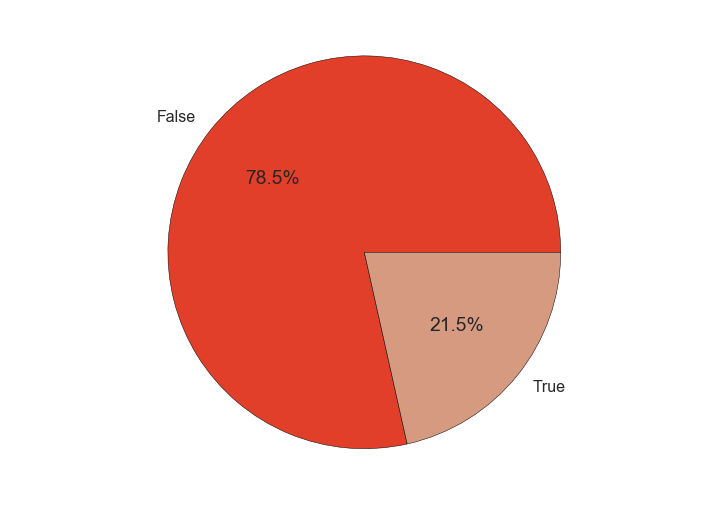

In [15]:
ExploreData(df_reserved_init_train_set)

# Train and Classify with the initial training 

In [16]:
TrainAndClassify_SVM(df_reserved_init_train_set, df_test)

Predicted  False  True   All
Actual                      
False       6255    87  6342
True         790   511  1301
All         7045   598  7643

Accuracy:  0.885254481225

             precision    recall  f1-score   support

      False       0.89      0.99      0.93      6342
       True       0.85      0.39      0.54      1301

avg / total       0.88      0.89      0.87      7643



# Baseline training set + L randomly selected  

<img src="RANDOM.png">

Training data has:  400  documents
Index(['DOCID', 'NOTE_TEXT', 'CATEGORY'], dtype='object')
The shape of the data is  (400, 3)


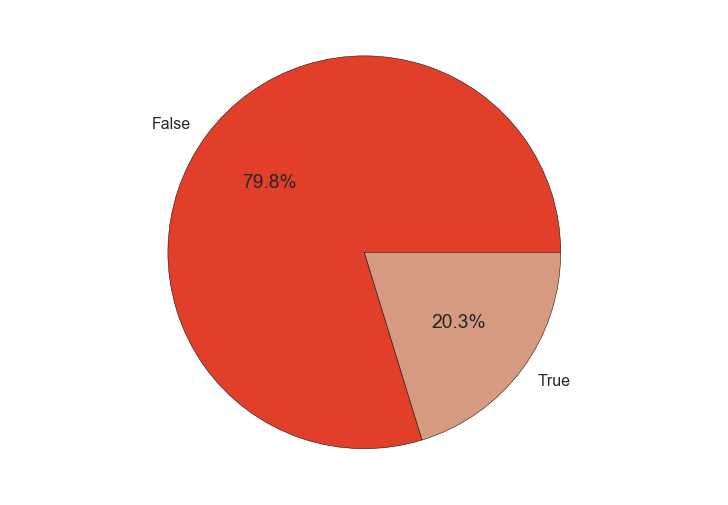

In [17]:
# Baseline training set + L randomly selected

# Create a copy of the initial training set
df_random_sample_train_set = df_reserved_init_train_set.copy(deep=True)

L_random_indices = random.sample(range(0, len(df_train.index)), L)

df_random_sample_train_set = MoveIndices(df_train, df_random_sample_train_set, L_random_indices)  

ExploreData(df_random_sample_train_set)

In [18]:
TrainAndClassify_SVM(df_random_sample_train_set, df_test)

Predicted  False  True   All
Actual                      
False       6274    68  6342
True         784   517  1301
All         7058   585  7643

Accuracy:  0.888525448122

             precision    recall  f1-score   support

      False       0.89      0.99      0.94      6342
       True       0.88      0.40      0.55      1301

avg / total       0.89      0.89      0.87      7643



# Results (so far) summary

| Training set | Accuracy | True-recall | True-f1-score |        
| ------------- | ------------- | ------------- | ------------- |
| 200 randomly selected | 0.885 | 0.39 | 0.54 |
| 200 randomly selected + 200 randomly selected | 0.888 | 0.40 | 0.55 |

# Add samples to the training set using Active Learning


<img src="ACTIVE.png">

In [19]:
# Citation:: 'http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_probas.html' 

# Active Learning - Committee-Based Sampling

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

def ActiveLearn(df_train, df_candidates, L):
    """
    Implementation of the Active Learning algorithm Committee-Based Sampling.
    Selects the L most informative records from the labeled set df_candidates,
    , copies them to df_train and returns the extended df_train
    """  
    
    # The classifiers in our Committee-of-classifiers
    clf1 = LogisticRegression(random_state=123)
    clf2 = RandomForestClassifier(random_state=123)
    clf3 = GaussianNB()

    # Extract the relevant data 
    X_train = df_train['NOTE_TEXT'].tolist()
    Y_train = df_train.CATEGORY.tolist()
    X_candidates = df_candidates['NOTE_TEXT'].tolist()
    
    # Convert from text to word counts
    vectorizer = CountVectorizer(tokenizer=tokenize, ngram_range=(1,2))
    wcounts_train = vectorizer.fit_transform(X_train)    
    wcounts_candidates = vectorizer.transform(X_candidates)
    
    # Use each member in the Committee-of-classifiers to predict true/false probabilities
    probas = [c.fit(wcounts_train.toarray(), Y_train).predict_proba(wcounts_candidates.toarray()) 
              for c in (clf1, clf2, clf3)]
    
    K = len(df_candidates.index)
    
    # For each record - calculate one value that represents the level of disagreement
    # between all the members in the Committee-of-classifiers 
    np_doc_id_pr = np.empty((K,2), dtype=np.float64)
    num_classifer_method = 3

    for row_index in range(K):
    
        false_pr = 0.0
        true_pr = 0.0

        for x in range(num_classifer_method-1):
            false_pr += abs(probas[x][row_index][0] - probas[x+1][row_index][0])
            true_pr += abs(probas[x][row_index][1] - probas[x+1][row_index][1])

        amortizeVotingClassifier = abs(false_pr - true_pr)

        np_doc_id_pr[row_index][0] = row_index
        np_doc_id_pr[row_index][1] = amortizeVotingClassifier
    
    tmp_np_array =  np_doc_id_pr[np_doc_id_pr[:,1].argsort()[::-1]]
    
    # Add to the training set the L samples with the highest values of disagreement
    for i in range(L):
        df_train = df_train.append(df_candidates.iloc[int(tmp_np_array[i][0])])
    return df_train



In [20]:
# Create a copy of the initial training set
df_active_learning_train_set = df_reserved_init_train_set.copy(deep=True)

L_random_indices = random.sample(range(0, len(df_train.index)), L)


In [22]:
df_final_active_learning_dataset = ActiveLearn(df_active_learning_train_set,df_train, L)

Training data has:  400  documents
Index(['DOCID', 'NOTE_TEXT', 'CATEGORY'], dtype='object')
The shape of the data is  (400, 3)


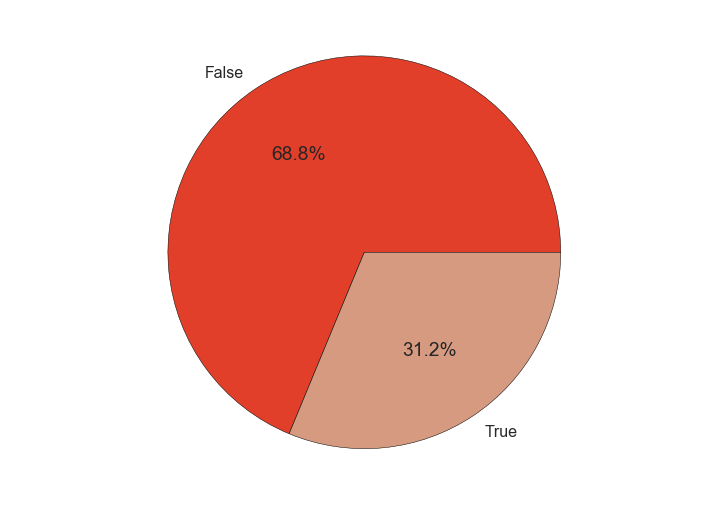

In [23]:
ExploreData(df_final_active_learning_dataset)

In [25]:
TrainAndClassify_SVM(df_final_active_learning_dataset, df_test)

Predicted  False  True   All
Actual                      
False       6195   147  6342
True         502   799  1301
All         6697   946  7643

Accuracy:  0.915085699333

             precision    recall  f1-score   support

      False       0.93      0.98      0.95      6342
       True       0.84      0.61      0.71      1301

avg / total       0.91      0.92      0.91      7643



# Results Summary

| Training set | Accuracy | True-recall | True-f1-score |        
| ------------- | ------------- | ------------- | ------------- |
| 200 randomly selected | 0.885 | 0.39 | 0.54 |
| 200 randomly selected + 200 randomly selected | 0.888 | 0.40 | 0.55 |
| 200 randomly selected + 200 selected by Committee-Based Sampling| **0.915** | **0.61** | **0.71** |
